Results of running GPT-2 on IMDb movie reviews without any fine-tuning

Train and test data exploration:
1. No of samples
2. No of positive / negative samples.
3. Length of the movie reviews

Predict the next word given the following prompt
 
'''
Review: The movie was awesome. Sentiment: Positive. 
Review: The performances were disappointing. Sentiment: Negative. 
Review: {review} Sentiment:
'''
I calculate the probabilities of the word " Positive" and " Negative" and classify the review based on which probability is greater.

In [121]:
# Dataset exploration
import pandas
from torch.utils.data import Dataset
from sentiment_classification.reviewsDataset import reviewsDataset

imdb_train = reviewsDataset("train",max_length=10000)
imdb_test = reviewsDataset("test",max_length=10000)


def format_data(dataset: Dataset) -> pandas.DataFrame:

    data = []
    for batch in dataset:
        data.append({"input_ids":len(batch["input_ids"]),
                    "label": batch["label"],
                    "filename": batch["fpath"]})
    
    return pandas.DataFrame(data)

train_data = format_data(imdb_train)
test_data = format_data(imdb_test)


Summary statistics of the dataset

In [122]:
def summary(data: pandas.DataFrame) -> None:
    print(f"Number of reviews: {len(data)}")
    print(f"Positive Reviews: {data[data['label'] == 1]['label'].count()}")
    print(f"Negative Reviews: {data[data['label'] == 0]['label'].count()}")
    print(f"Max Review Length: {data['input_ids'].max()}\nMin Review Length: {data['input_ids'].min()}")
    print(f"Median Review Length: {data['input_ids'].median()}\nMean Review Length: {data['input_ids'].mean()}")

print("Train\n--------------")
summary(train_data)
print("Test\n---------------")
summary(test_data)

Train
--------------
Number of reviews: 25000
Positive Reviews: 12500
Negative Reviews: 12500
Max Review Length: 3066
Min Review Length: 40
Median Review Length: 243.0
Mean Review Length: 317.80192
Test
---------------
Number of reviews: 25000
Positive Reviews: 12500
Negative Reviews: 12500
Max Review Length: 2795
Min Review Length: 37
Median Review Length: 241.0
Mean Review Length: 311.11604


Length of reviews (measured by the number of tokens)

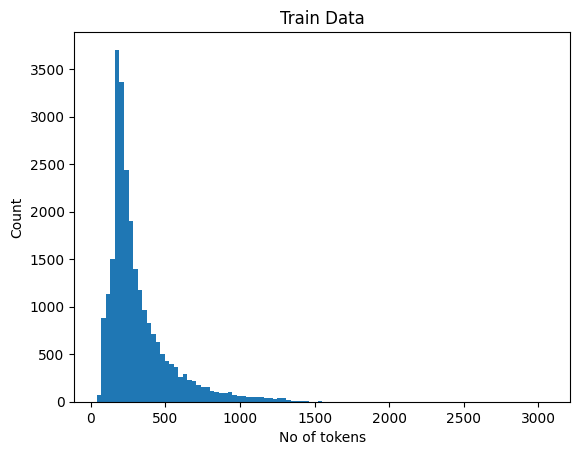

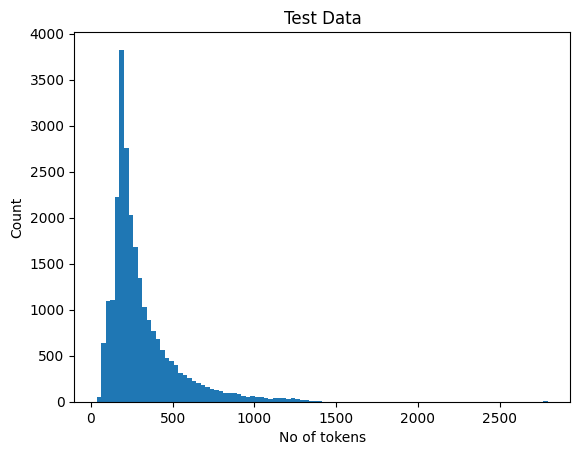

In [125]:
from matplotlib import pyplot as plt
def plot_hist(title: str,df: pandas.DataFrame) -> None:
    plt.figure()
    plt.hist(df["input_ids"],bins=100)
    plt.xlabel(f"No of tokens")
    plt.ylabel("Count")
    plt.title(f"{title}")

plot_hist(title='Train Data', df=train_data) 
plot_hist(title="Test Data", df=test_data)   

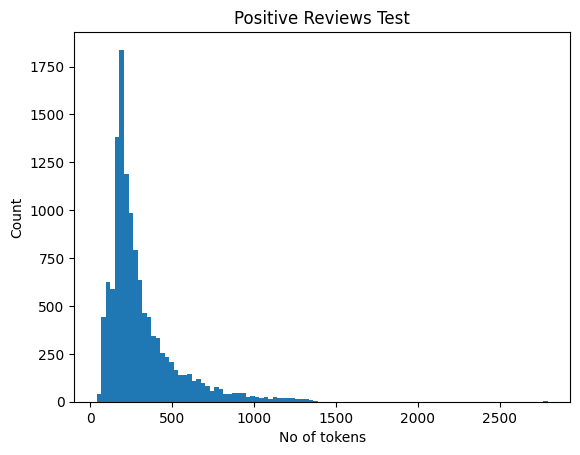

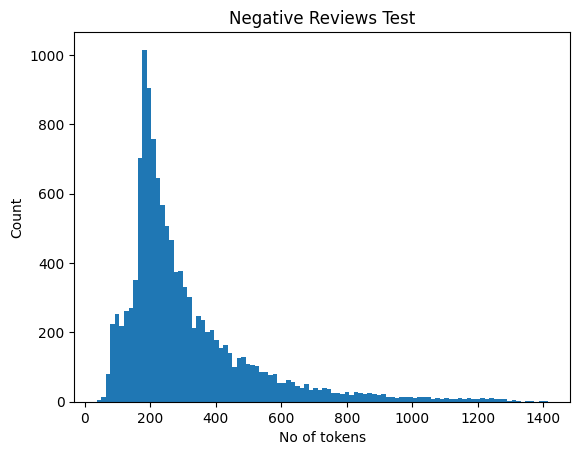

In [126]:
plot_hist(title="Positive Reviews Test",df=test_data[test_data['label']==1])
plot_hist(title="Negative Reviews Test",df=test_data[test_data['label']==0])

Run the test.py in `sentiment_classification` and write the results to a file

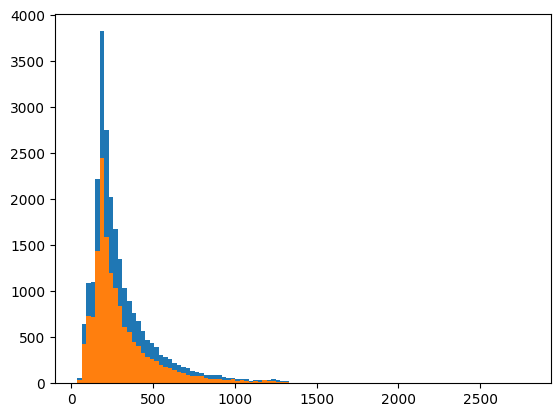

In [127]:
res_file = pandas.read_csv("sentiment_classification/zero_shot_256.txt")

In [128]:
bins = range(0,1500,128)
res_file["bin"] = pandas.cut(res_file['length'],bins)
metrics_by_bin = res_file.groupby('bin').apply(lambda x: pandas.Series({"TP": ((x["label"]==1) & (x["prediction"]==1)).sum(),
                                                                        "FP":((x["label"]==0) & (x["prediction"]==1)).sum(),
                                                                        "FN": ((x["label"]==1) & (x["prediction"]==0)).sum(),
                                                                        "TN": ((x["label"]==0) & (x["prediction"]==0)).sum()}))

metrics_by_bin["accuracy"] = (metrics_by_bin["TP"] + metrics_by_bin["TN"])/(metrics_by_bin["TP"] + metrics_by_bin["TN"]+ metrics_by_bin["FP"]+ metrics_by_bin["FN"])
metrics_by_bin["precision"] = metrics_by_bin["TP"]/(metrics_by_bin["TP"] + metrics_by_bin["FP"])
metrics_by_bin["recall"] = metrics_by_bin["TP"]/(metrics_by_bin["TP"] + metrics_by_bin["FN"])
print(metrics_by_bin)


                TP    FP   FN    TN  accuracy  precision    recall
bin                                                               
(0, 128]       691   241  495   730  0.658785   0.741416  0.582631
(128, 256]    4836  3482  885  2291  0.620063   0.581390  0.845307
(256, 384]    1989  1480  659  1351  0.609600   0.573364  0.751133
(384, 512]     882   672  365   658  0.597594   0.567568  0.707298
(512, 640]     491   329  174   364  0.629602   0.598780  0.738346
(640, 768]     281   170  126   182  0.610013   0.623060  0.690418
(768, 896]     161   114   73   109  0.590810   0.585455  0.688034
(896, 1024]    113    69   45    65  0.609589   0.620879  0.715190
(1024, 1152]    58    43   43    49  0.554404   0.574257  0.574257
(1152, 1280]    68    37   19    43  0.664671   0.647619  0.781609
(1280, 1408]    26     5   13    15  0.694915   0.838710  0.666667


/var/folders/p1/qmcgqwhj1mx925j0j_r36xp40000gn/T/ipykernel_7361/694942158.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  metrics_by_bin = res_file.groupby('bin').apply(lambda x: pandas.Series({"TP": ((x["label"]==1) & (x["prediction"]==1)).sum(),
/var/folders/p1/qmcgqwhj1mx925j0j_r36xp40000gn/T/ipykernel_7361/694942158.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_by_bin = res_file.groupby('bin').apply(lambda x: pandas.Series({"TP": ((x["label"]==1) & (x["prediction"]==1)).sum(),
